In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import CorrMaps as CM

# Load MI file

```MIfile``` class interacts with MIfiles: read them and write them, and handles metadata from external configuration files.
To load a MIfile together with associated metadata, use:

```python
mi_file = MI.MIfile(MI_filename, Metadata_filename)
```

In [2]:
froot = os.path.join(os.path.dirname(MI.__file__), 'test')
fname = os.path.join(froot, 'MIfile.dat')
metadata_fname = os.path.join(froot, 'metadata.ini')
mi_file = MI.MIfile(fname, metadata_fname)

```MIfile``` class doesn't load any data from the source MIfile upon initializion.
Data can be retrieved using one of the following functions:

```python
mi_file.Read(zRange=None, cropROI=None, closeAfter=False) #Read multiple images or ROIs from MIfile
mi_file.GetImage(img_idx, cropROI=None) #Read single image or ROI from MIfile
mi_file.GetStack(start_idx=0, imgs_num=-1) #Read contiguous image stack from MIfile
```

Here, ```cropROI``` has to be a 4-element tuple of the form: ```[x, y, w, h]```, 
where ```(x, y)``` is the coordinate of the top-left corner of the ROI (0-based) 
and ```(w, h)``` are width and height, respectively. Setting either ```w``` or ```h``` to ```-1```
indicates that the dimension extends to the image boundary.

Before any reading operation, file handle must be initialized using 

```python
mi_file.OpenForReading()
```

At the end of any reading operation, file handle must be freed using

```python
mi_file.Close()
```

### Test MIfile class

The structure of the MIfile class can be print to output in two ways:

In [3]:
mi_file

<MIfile: 0+2x200x300x1 bytes>

In [4]:
print(mi_file)


|---------------|
| MIfile class: |
|---------------+---------------
| Filename      : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test\MIfile.dat
| Header        : 0 bytes
| Shape         : [2, 200, 300] px
| Pixel format  : B (1 bytes/px)
| Status        : Closed
|---------------+---------------


To get a feeling of what's inside the MIfile let's display one random frame:

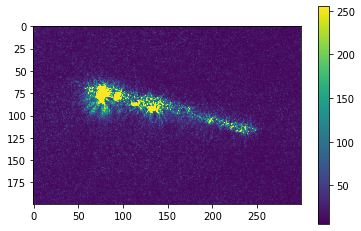

In [5]:
mi_file.OpenForReading()
sample_ROI = mi_file.GetImage(0)
plt.imshow(sample_ROI)
plt.colorbar()

Each MIfile has associated metadata, contained in a ```DSH.Config``` object:

In [6]:
mi_file.MetaData

<Config class: 2 sections, 7 keys>

In [7]:
print(mi_file.MetaData)


|---------------|
| Config class: |
|---------------+---------------
| Section count : 2
| Total keys    : 7
| MIfile        : <6 keys>
|                 hdr_len = 0
|                 px_format = B
|                 fps = 10
|                 px_size = 1
|                 shape = [2, 200, 300]
|                 comments = sample multi image MIfile
| settings      : <1 keys>
|                 max_buffer_size = 100000000
|---------------+---------------


```MIfile```-specific metadata can be exported as a dictionary by calling ```mi_file.GetMetadata()```:

In [8]:
mi_file.GetMetadata()

{'hdr_len': '0',
 'px_format': 'B',
 'fps': '10',
 'px_size': '1',
 'shape': '[2, 200, 300]',
 'comments': 'sample multi image MIfile'}

### Export MIfile

To export a chunk of MIfile, we can use:

```python
mi_file.Export(mi_filename, metadata_filename, zRange=None, cropROI=None)
```

Let's use it to export two cropped frames to two different files:

In [9]:
test_ROI = [200, 100, -1, 50]
for i in range(2):
    exp_mi_fname = os.path.join(froot,'MIfile_{0}.dat'.format(i+1))
    exp_meta_fname = os.path.join(froot,'metadata_{0}.ini'.format(i+1))
    mi_file.Export(exp_mi_fname, exp_meta_fname, zRange=[i, i+1], cropROI=test_ROI)

Let's test that the export was successful:

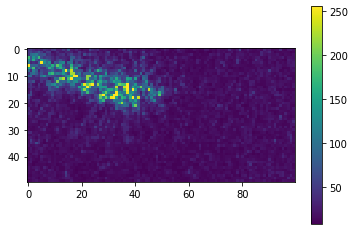

In [10]:
exp_mi_file = MI.MIfile(exp_mi_fname, exp_meta_fname)
exp_mi_file.OpenForReading()
plt.imshow(exp_mi_file.GetImage(0))
plt.colorbar()

# MIstacks

Several MIfiles with common metadata (in particular, same shape **and** image numbers are required) can be handled together as a ```MIstack``` object, that can be initialized like this:

```python
mi_stack = MIs.MIstack(MIfiles=[], MetaData=None, MetaDataSection=None, Load=False, OpenFiles=True, StackType='tau')
```

where:
- ```MIfiles``` is a list of input ```MIfile``` objects
- ```MetaData``` (```str``` or ```dict```) is the metadata common to all MIfiles. If ```string```, it is interpreted as the filename of metadata file.
- ```MetaDataSection``` (```str``` or ```None```) denotes the section to be loaded (```None``` loads all sections)
- ```StackType``` ```{'tau', 't'}``` indicates whether the MIfiles are meant to be concatenated along the time (z) axis (stack type ```'t'```) or to be stacked along an additional dimension (stack type ```'tau'```, default)

A practical way to load multiple MIfiles in the same folder is through the function

```python
mi_stack = MIs.LoadFolder(mi_folder, config_fname, config_section='MIfile', mi_prefix='', mi_ext='.dat', mi_sort='ASC', open_mifiles=True, stack_type='tau')
```

In [11]:
mi_stack = MIs.LoadFolder(froot, exp_meta_fname, mi_prefix='MIfile_', stack_type='t')
mi_stack

<MIstack [t]: 2x1x50x100x1 bytes>

In [12]:
print(mi_stack)


|----------------|
| MIstack class: |
|----------------+---------------
| MIfile number  : 2
| MIshape        : [1, 50, 100] px
| Image number   : 2
| Pixel format   : B (1 bytes/px)
| Stack type     : t
|----------------+---------------


There are 2 images, which can be accessed with a ```GetImage()``` method analogous to the ```MIfile``` one:

```python
MIs.MIstack.GetImage(img_idx, MI_idx=None, cropROI=None)
```

where ```MI_idx``` indicates the index of the ```MIfile```. If it is ```None``` (default), ```img_idx``` ranges from 0 to ```mi_stack.ImageNumber()``` and is interpreted as the index of the image since the beginning of the stack. In this case, the ```MIstack``` is effectively treated as a ```MIfile``` with a large number of images. Otherwise, if MI_idx is given, ```img_idx``` ranges from 0 to ```mi_stack.ImgsPerMIfile``` and the function is equivalent to the child's ```MI.MIfile.GetImage()``` function

0


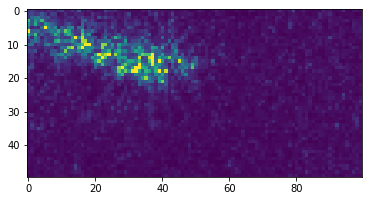

In [13]:
plt.imshow(mi_stack.GetImage(1))
print(np.count_nonzero(mi_stack.GetImage(1)!=mi_stack.GetImage(0, MI_idx=1)))